# Question 1

In [114]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import cmath
import math

In [2]:
book_input = cv2.imread('../imgs/book.jpg',0)
book = cv2.resize(book_input,(512,512))

In [3]:
def blurring(img,a,b,T):
    
    # Finding fft of image
    img_fft = np.fft.fftshift(np.fft.fft2(book))
    
    # Code to find filter
    center_x = img.shape[0]//2
    center_y = img.shape[1]//2
    
    filt = np.zeros((img.shape),dtype = complex)
    
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            u = i - center_x
            v = j - center_y
            
            t = (u*a+v*b)
            
            comp1 = np.sin(np.pi*(t))
            comp2 = (cmath.e)**(-1j*t*np.pi)
            
            if abs(t) > 0.0001:
                filt[i][j] = (T*comp1*comp2)/(np.pi*t)
            else:
                filt[i][j] = T*comp2
    
    
    # Multiplying to get fft of blurred image
    blur_fft = img_fft * filt
    
    # Inverse Fourier 
    output_image = np.fft.ifft2(np.fft.ifftshift(blur_fft))
    
    return np.abs(output_image)

In [4]:
# Normalize function
def normalize(img):
    img = img - np.min(img)
    img = img/np.max(img)
    img = 255*img
    img = img.astype('uint8')
    
    return img

In [5]:
def inverse_blurring(img,a,b,T):
    
    # Finding fft of image
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    
    # Code to find filter
    center_x = img.shape[0]//2
    center_y = img.shape[1]//2
    
    unblur_filt = np.zeros((img.shape),dtype = complex)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            u = i - center_x
            v = j - center_y
            
            t = (u*a+v*b)
            
            comp1 = np.sin(np.pi*(t))
            comp2 = cmath.e**(-1j*t*np.pi)
            
            if abs(comp1) > 0.0001:
                unblur_filt[i][j] = (np.pi*t)/(T*comp1*comp2)
            else:
                unblur_filt[i][j] = 1/(T*comp2)
    
    
    # Multiplying to get fft of blurred image
    unblur_fft = img_fft * unblur_filt
    
    # Inverse Fourier 
    output_image = np.fft.ifft2(np.fft.ifftshift(unblur_fft))
    
    return np.abs(output_image)

In [6]:
def add_gaussian_noise(img,mean,var):
    sig = var ** 0.5
    
    gaussian_noise = np.random.normal(mean,sig,img.shape)
    
    final_img = img + gaussian_noise
    
    final_img = normalize(final_img)
    
    return final_img

# Part 2

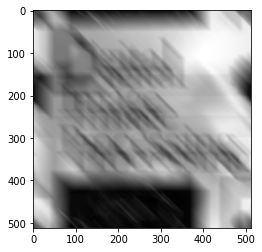

In [7]:
blur_img = blurring(book,0.1,0.1,1)
plt.imshow(blur_img,cmap = 'gray')

## Part 3

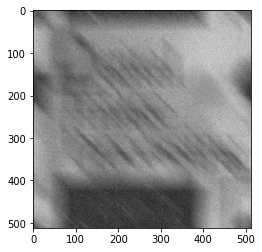

In [8]:
noisy_blur_img = add_gaussian_noise(blur_img,mean = 0,var = 650)
plt.imshow(noisy_blur_img,cmap = 'gray')

## Part 4

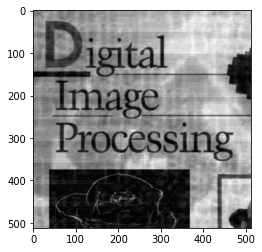

In [9]:
restored_img = inverse_blurring(blur_img,0.1,0.1,1)
plt.imshow(restored_img,cmap = 'gray')

## Part 5 - Weiner Deconvolution

In [10]:
def weiner_filter(img,a,b,T,K):
    
    # Finding fft of image
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    
    # Finding the H filter
    
    center_x = img.shape[0]//2
    center_y = img.shape[1]//2
    
    filt = np.zeros((img.shape),dtype = complex)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            u = i - center_x
            v = j - center_y
            
            t = (u*a+v*b)
            
            comp1 = np.sin(np.pi*(t))
            comp2 = 1/math.e**(1j*t*np.pi)
            
            if abs(t) > 0.001:
                filt[i][j] = (T*comp1*comp2)/(np.pi*t)
            else:
                filt[i][j] = T*comp2
    
    
    # Finding the weiner filter
    weiner_filter = np.zeros(img.shape,dtype = complex)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.abs(filt[i][j])**2 >= 0.0001:
                weiner_filter[i][j] = (np.abs(filt[i][j])**2)/(filt[i][j]*(np.abs(filt[i][j])**2 + K))
            else:
                weiner_filter[i][j] = 0
    
    # Multiplying the Image FFT with Weiner Filter
    unblur_fft = weiner_filter*img_fft
    
    # Computing the inverse fft of unblur fft
    unblur_img = np.fft.ifft2(np.fft.ifftshift(unblur_fft))
    
    return np.abs(unblur_img)

In [11]:
weiner_restored_img = weiner_filter(noisy_blur_img,0.1,0.1,1,0.01)

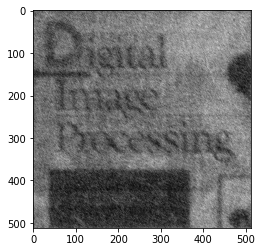

In [12]:
plt.imshow(weiner_restored_img,cmap = 'gray')

## Part 6 - Comparision

In [13]:
gaussian_var1 = add_gaussian_noise(blur_img,mean = 0,var = 1)
gaussian_var10 = add_gaussian_noise(blur_img,mean = 0,var = 10)
gaussian_var500 = add_gaussian_noise(blur_img,mean=0,var = 500)
gaussian_var5000 = add_gaussian_noise(blur_img,mean = 0,var = 5000)

In [14]:
restored_var1 = weiner_filter(gaussian_var1,0.1,0.1,1,0.01)
restored_var10 = weiner_filter(gaussian_var10,0.1,0.1,1,0.01)
restored_var500 = weiner_filter(gaussian_var500,0.1,0.1,1,0.01)
restored_var5000 = weiner_filter(gaussian_var5000,0.1,0.1,1,0.01)

Text(0.5, 1.0, 'Variance = 5000')

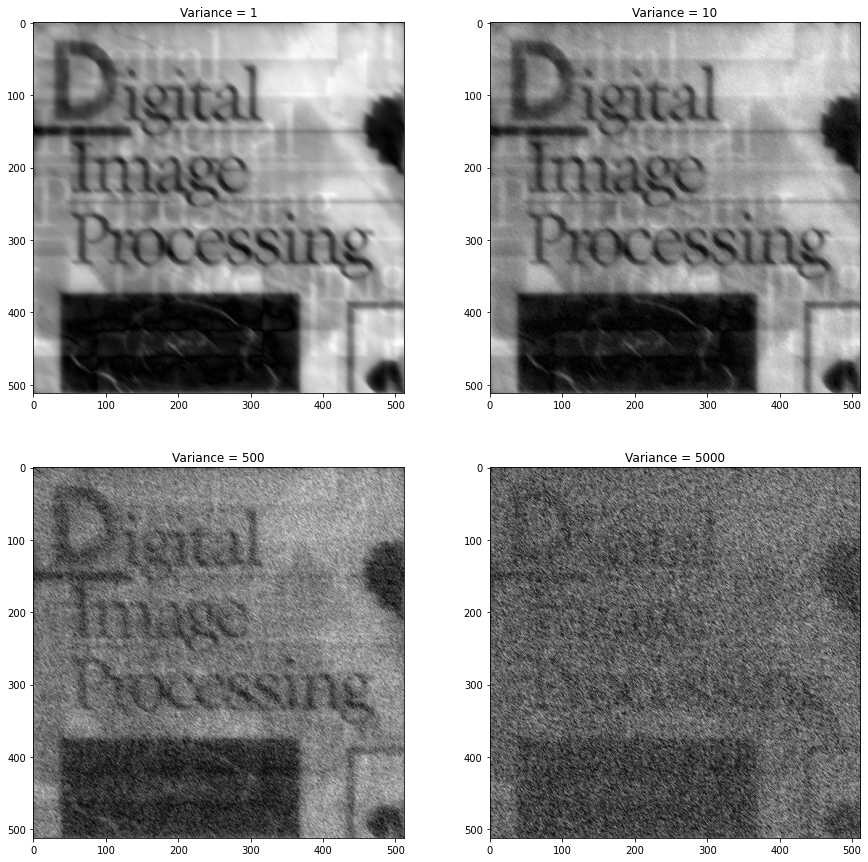

In [15]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

plt.subplot(221)
plt.imshow(restored_var1,cmap = 'gray')
plt.title("Variance = 1")
plt.subplot(222)
plt.imshow(restored_var10,cmap = 'gray')
plt.title('Variance = 10')
plt.subplot(223)
plt.imshow(restored_var500,cmap = 'gray')
plt.title('Variance = 500')
plt.subplot(224)
plt.imshow(restored_var5000,cmap = 'gray')
plt.title('Variance = 5000')

## Observation

From the above plots we can clearly observe that as the variance increases the quality of restoration provided by the Weiner Filter decreases i.e., as Variance increases, restored image quality decreases but with low variance we can observe that there are copies of the word "Digital Image Proessing" being shown

# Question 2

## Huffman Encoding

In [344]:
def huffman_encode(image):
    
    image = image.copy()
    flattened_img = image.flatten()
    prob = dict()
    for i in range(len(flattened_img)):
        if flattened_img[i] in prob:
            prob[flattened_img[i]] = prob[flattened_img[i]] + 1
        else:
            prob[flattened_img[i]] = 1
            
            
    prob = sorted(prob.items(),key = lambda  x: x[1])
    
    #print(prob)
    
    while True:
        if len(prob) <= 1:
            break
        # Pop used as a queue data structure
        left_child = prob.pop(0)
        right_child = prob.pop(0)
        left_val = left_child[0]
        right_val = right_child[0]
        parent = (left_val,right_val)
        comb_prob = left_child[1] + right_child[1]
        temp = (parent,comb_prob)
        prob.append(temp)
        prob = sorted(prob,key = lambda x:x[1])
        
    res = dict()
    #print(prob)
    
    def tree_tr(parent,route):
        if isinstance(parent,tuple):
            temp1 = route + '0'
            temp2 = route + '1'
            tree_tr(parent[0],temp1)
            tree_tr(parent[1],temp2)
        else:
            res[parent] = route
            
    tree_tr(prob[0][0],'')
    encoded_str = ''
    for i in range(len(flattened_img)):
        encoded_str += res[flattened_img[i]]
    return encoded_str, res


def huffman_decode(encoded_str,res,image_shape):
    reconstructed_seq = list()
    while len(encoded_str) > 0:
        for i in range(1,len(res)):
            if encoded_str.startswith(res[res[i]]):
                num_str = str(res[i])
                reconstructed_seq.append(num_str)
                encoded_str = encoded_str[len(res[res[i]]):]
                break
    encoded_str = np.array(encoded_str)
    reconstructed_img = encoded_str.reshape(image_shape)
    reconstructed_img = reconstructed_img.astype('uint8')
    return reconstructed_img

In [345]:
encoded_str,res = huffman_encode(input_image)

In [347]:
reconstructed_image = huffman_decoding(encoded_str,res,input_image.shape)

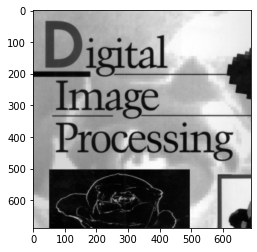

In [349]:
plt.imshow(reconstructed_image,cmap = 'gray')

In [350]:
C_r = input_image.size/(len(encoded_str)/8)

In [352]:
print("The compression ratio in case of Huffman Coding is ",C_r)

The compression ratio in case of Huffman Coding is  1.0726905191402958


## Run Length Encoding

In [353]:
def RLE_encode(image):
    
    image = image.copy()
    flattened_img = image.flatten()
    
    prev = flattened_img[0]  
    N = len(flattened_img) - 1
    
    encode_arr = list()
    
    counter = 1
    
    for i in range(1,N):
        if flattened_img[i] == prev:
            counter += 1
            prev = flattened_img[i]
        else:
            encode_arr.append((prev,counter))
            counter = 1
            prev = flattened_img[i]
    
    encode_arr.append((prev,counter))
    encode_arr.append((flattened_img[-1],counter))
    
    return encode_arr


def RLE_decode(code,image_shape):
    restored_image = []
    
    N = len(code)
    
    for i in range(N):
        extracted_num = code[i][0]
        sequence = [extracted_num] * code[i][1]
        restored_image += sequence
    
    restored_image = np.array(restored_image)
    restored_image = restored_image.reshape(image_shape)
    
    return restored_image

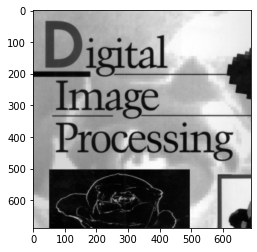

In [354]:
input_image = cv2.imread('../imgs/book.jpg', 0)
image_shape = input_image.shape


code = RLE_encode(img)
decoded_image = RLE_decode(code, image_shape)
C_r = input_image.size / len(code)

plt.imshow(decoded_image, cmap='gray')

In [355]:
print('Compression ratio of Run Length Encoding is:', C_r)

Compression ratio of Run Length Encoding is: 1.47113633396943


## LZW Encoding

In [356]:
def LZW_encode(image):
    
    image = image.copy()
    flattened_img = image.flatten()
    N = len(flattened_img)
    
    encode_dictionary = dict()
    for i in range(256):
        encode_dictionary[chr(i)] = i
        
    init = 256
    prev = ''
    encode_arr = list()
    for i in range(N):
        char = chr(flattened_img[i])
        new = prev + char
        
        if new in encode_dictionary:
            prev = new
        else:
            encode_arr.append(encode_dictionary[prev])
            encode_dictionary[new] = init
            init += 1
            prev = char
            
    if len(prev) != 0:
        encode_arr.append(encode_dictionary[prev])
    return encode_arr

In [357]:
def LZW_decode(code,image_shape):
    
    decode_dictionary = dict()
    for i in range(256):
        decode_dictionary[i] = chr(i)
    
    N = len(code)
    
    init = 256
    restored_str = ''
    prev = chr(code[0])
    restored_str += prev
    
    
    for i in range(1,N):
        
        if code[i] in decode_dictionary:
            temp = decode_dictionary[code[i]]
            
        elif code[i] == init:
            temp = prev + prev[0]
            
        restored_str += temp
        decode_dictionary[init] = prev + temp[0]
        init += 1
        prev = temp
        
    restored_img = []
    for i in restored_str:
        restored_img.append(ord(i))
    restored_img = np.array(restored_img)
    restored_img = restored_img.reshape(image_shape)
    
    return restored_img

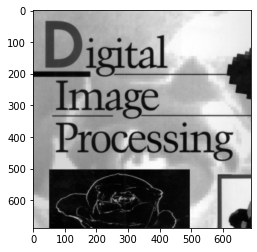

In [358]:
input_image = cv2.imread('../imgs/book.jpg', 0)
image_shape = input_image.shape


code = LZW_encode(input_image)
decoded_image = LZW_decode(code, image_shape)
C_r = input_image.size / len(code)

plt.imshow(decoded_image, cmap='gray')

In [359]:
print('Compression ratio of LZW is :', C_r)

Compression ratio of LZW is : 3.4655128233287207


## DCT Compression

In [367]:
def DCT_encode(image,quality):
    image = image.copy()
    
    h= image.shape[0]
    w = image.shape[1]
    rows = (np.linspace(0,h-1,h)).astype(int)
    cols = (np.linspace(0,w-1,w)).astype(int)
    
    xv, yv = np.meshgrid(rows,cols)
    pi = np.pi
    
    matrix_dct = np.power((2/h),0.5)*np.cos(pi*(2*xv+1)*yv/(2*h))
    matrix_dct[yv == 0] = 1/np.power(h,0.5)
    #print(matrix_dct)
    
    compressed_img = np.zeros(image.shape)
    
    image = image.astype(float)/255.0
    temp1 = np.dot(image,matrix_dct.T)
    temp1 = np.dot(matrix_dct,temp1)
    
    quant_value = 75
    compressed_img[:quality,:quality] = temp1[:quality,:quality]
    
    return np.array(compressed_img),quant_value

In [368]:
def DCT_decode(image_dct):
    image = image_dct.copy()
    
    h= image.shape[0]
    w = image.shape[1]
    rows = (np.linspace(0,h-1,h)).astype(int)
    cols = (np.linspace(0,w-1,w)).astype(int)
    
    xv, yv = np.meshgrid(rows,cols,indexing='xy')
    pi = np.pi
    
    matrix_dct = np.power((2/h),0.5)*np.cos(pi*(2*xv + 1)*yv/(2*h))
    matrix_dct = matrix_dct
    matrix_dct[yv == 0] = 1/np.power(h,0.5)
    
    
    temp1 = np.dot(image_dct,matrix_dct)
    restored_img = np.dot(matrix_dct.T,temp1)
    
    return restored_img

In [370]:
dct_img,quant_value = DCT_encode(input_image,quality=75)

In [371]:
restored_img = DCT_decode(dct_img)

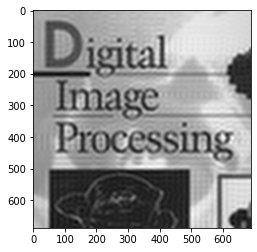

In [372]:
plt.imshow(restored_img,cmap = 'gray')

In [376]:
quality = 75

In [377]:
C_r = (input_image.shape[0]*input_image.shape[1])/quality**2

In [378]:
print("The compression ratio in DCT Encoding is :",C_r)

The compression ratio in DCT Encoding is : 84.15004444444445


## Huffman Coding
Pros: - It is a variable length code so it will be more efficient. It uses the prior knowledge of the data.<br>
Cons: - Very slow and requires heavy computation.

## RLE Coding

Pros - Easy to implement and can be stacked with other encoding methods like huffman <br>
Cons - It does not offer much compression and can increase the size if the there is no repetitive pattern in the image since it depends on continuous occurences of pixel values.

## LZW Coding
Pros - Fast and easy to implement, dictionary is directly understandable for humans and also because all codes have same dimension <br>
Cons - The amount of storage needed is highly unpredictable as it depends on the string's total length

## DCT Compression
Pros - Gives very high compression ratio due to lossy nature and also minimizes blocking artefacts and handles interpixel redundance <br>
Cons - It can have high time complexity in certain cases and also it is a lossy compression